<a href="https://colab.research.google.com/github/rockaguirre/Neuro-140-Project/blob/main/GITHUB_neuro140_final_project_raguirre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import *
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from PIL import Image, ImageEnhance

In [2]:
train_directory = '/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Training'
test_directory = '/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Testing'

In [3]:
classifications = ['notumor', 'glioma','meningioma', 'pituitary']

data_train = []
classifications_train = []
data_test = []
classifications_test = []

In [4]:
image_size = 128

for label in classifications:
  path = os.path.join(train_directory, label)
  names = os.listdir(path)
  for item in range(len(names)):
      image = cv2.imread(os.path.join(path, names[item]))
      image = cv2.resize(image, (image_size, image_size))
      data_train.append(image)
      classifications_train.append(label)

for label in classifications:
  path = os.path.join(test_directory, label)
  names = os.listdir(path)
  for item in range(len(names)):
      image = cv2.imread(os.path.join(path, names[item]))
      image = cv2.resize(image, (image_size, image_size))
      data_test.append(image)
      classifications_test.append(label)

data_train = np.array(data_train)
classifications_train = np.array(classifications_train)
data_test = np.array(data_test)
classifications_test = np.array(classifications_test)

In [5]:
data_train.shape

(5712, 128, 128, 3)

In [6]:
data_test.shape

(1311, 128, 128, 3)

In [7]:
data_train, classifications_train = shuffle(data_train, classifications_train, random_state=30)

In [8]:
# ensure shape is the same
data_train.shape

(5712, 128, 128, 3)

In [9]:
data_test.shape

(1311, 128, 128, 3)

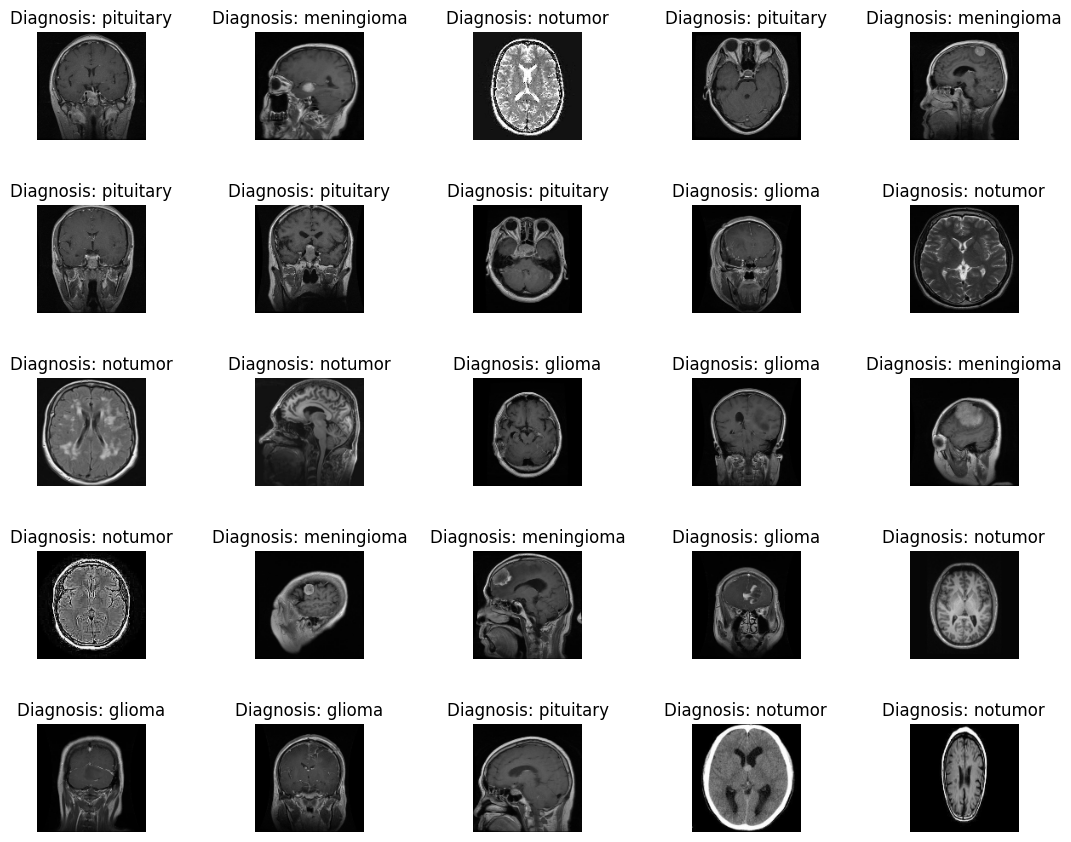

In [10]:
grid_width = 5
grid_height = 5

figure, axis = plt.subplots(grid_width, grid_height, figsize=(8,8))

img_idx = 0

for x in range(grid_width):
    for y in range(grid_height):
        axis[x][y].axis('off')
        axis[x][y].set_title('Diagnosis: '+ classifications_train[img_idx])
        axis[x][y].imshow(data_train[img_idx])
        img_idx += 1

# fix orientation and overlap of titles
plt.subplots_adjust(left=0, bottom=0, right=1.3, top=1, wspace=0.3, hspace=0.6)

In [11]:
# split dataset into train, test, and validation
data_train, data_test, classifications_train, classifications_test = train_test_split(data_train, classifications_train, test_size = 0.15, random_state=30)
data_train, data_validation, classifications_train, classifications_validation = train_test_split(data_train, classifications_train, test_size = 0.2, random_state=30)

In [12]:
classifications_train_updated = []
classifications_validation_updated = []
classifications_test_updated = []

# turn classifications like "glioma" into values
for label in classifications_train:
    classifications_train_updated.append(classifications.index(label))

# to_categorical to turn into a one hot encoded representation -- do not %100 understand but it helped fix a problem -- chatGPT told me to try
classifications_train = to_categorical(classifications_train_updated)

for label in classifications_validation:
    classifications_validation_updated.append(classifications.index(label))

classifications_validation = to_categorical(classifications_validation_updated)


for label in classifications_test:
    classifications_test_updated.append(classifications.index(label))

classifications_test = to_categorical(classifications_test_updated)


In [13]:
classifications_train

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [14]:
general_model = VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
# set beginning layers to non-trainable to retain pre-trained weights from imagenet

for layer in general_model.layers:
    layer.trainable=False

# set last block to trainable for new dataset
general_model.layers[-2].trainable=True
general_model.layers[-3].trainable=True
general_model.layers[-4].trainable=True

# first CNN model
first_model = Sequential()
first_model.add(Input(shape=(image_size,image_size,3)))
first_model.add(general_model)
first_model.add(Flatten())
first_model.add(Dropout(0.2))
first_model.add(Dense(units=128, activation='relu'))
first_model.add(Dropout(0.2))
first_model.add(Dense(units=4, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
first_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
first_model.compile(optimizer=Adam(learning_rate = 0.001),loss='categorical_crossentropy', metrics= 'Accuracy')

In [19]:
# scale data to match array type float32

scale_data_train = data_train.astype('float32')
scale_data_test = data_test.astype('float32')
scale_data_validation = data_validation.astype('float32')

scale_data_train /= 255
scale_data_test /= 255
scale_data_validation /= 255

In [ ]:
batch_size = 32
epochs = 10

history = first_model.fit(x=scale_data_train, y=classifications_train,
                          validation_data=(scale_data_validation, classifications_validation),
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1)

Epoch 1/10
122/122 [==============================] - 1054s 9s/step - loss: 1.0641 - Accuracy: 0.5191 - val_loss: 0.5336 - val_Accuracy: 0.7528
Epoch 2/10
122/122 [==============================] - 1051s 9s/step - loss: 0.4782 - Accuracy: 0.8100 - val_loss: 0.3265 - val_Accuracy: 0.8764
Epoch 3/10
122/122 [==============================] - 1016s 8s/step - loss: 0.2913 - Accuracy: 0.8901 - val_loss: 0.3187 - val_Accuracy: 0.8888
Epoch 4/10
122/122 [==============================] - 1017s 8s/step - loss: 0.2690 - Accuracy: 0.9047 - val_loss: 0.3208 - val_Accuracy: 0.8795
Epoch 5/10
122/122 [==============================] - 1045s 9s/step - loss: 0.2122 - Accuracy: 0.9240 - val_loss: 0.2579 - val_Accuracy: 0.9217
Epoch 6/10
122/122 [==============================] - 1045s 9s/step - loss: 0.1755 - Accuracy: 0.9408 - val_loss: 0.5800 - val_Accuracy: 0.7642
Epoch 7/10
122/122 [==============================] - 1047s 9s/step - loss: 0.1736 - Accuracy: 0.9385 - val_loss: 0.2712 - val_Accuracy:

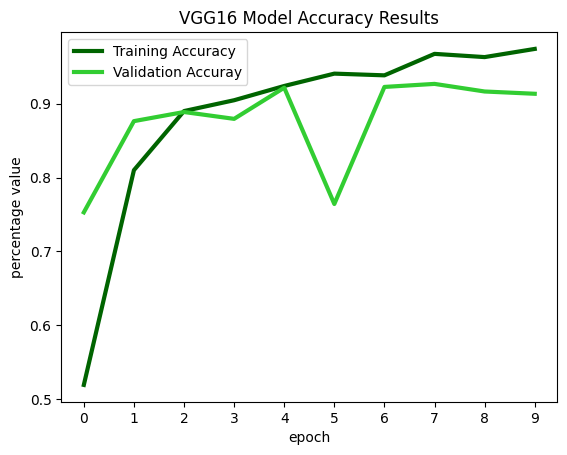

In [ ]:
plt.plot(history.history['Accuracy'], 'darkgreen', linewidth=3)
plt.plot(history.history['val_Accuracy'], 'limegreen', linewidth=3)
plt.title('VGG16 Model Accuracy Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Accuracy', 'Validation Accuray'], loc='upper left')
plt.show()

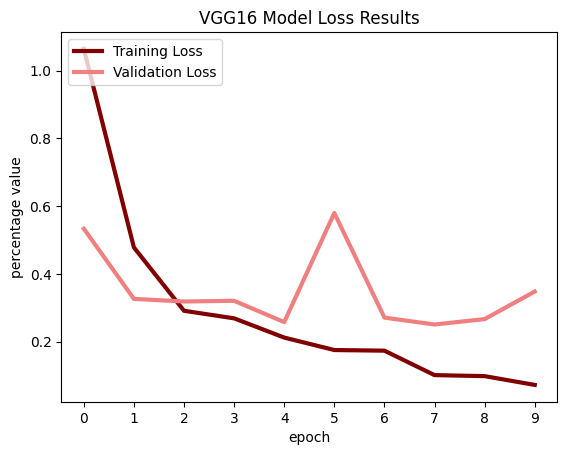

In [ ]:
plt.plot(history.history['loss'], 'maroon', linewidth=3)
plt.plot(history.history['val_loss'], 'lightcoral', linewidth=3)
plt.title('VGG16 Model Loss Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
predict_test = first_model.predict(scale_data_test)
predictions = np.argmax(predict_test, axis=1)
true_classification = np.argmax(classifications_test, axis=1)

print(classification_report(true_classification, predictions))

27/27 [==============================] - 155s 6s/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       217
           1       0.85      0.95      0.90       212
           2       0.94      0.73      0.82       199
           3       0.90      1.00      0.95       229

    accuracy                           0.92       857
   macro avg       0.92      0.91      0.91       857
weighted avg       0.92      0.92      0.91       857



In [16]:
second_general_model = ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
# set beginning layers to non-trainable to retain pre-trained weights from imagenet

for layer in second_general_model.layers[:-4]:
    layer.trainable = False
for layer in second_general_model.layers[-4:]:
    layer.trainable = True

# first CNN model
second_model = Sequential()
second_model.add(Input(shape=(image_size,image_size,3)))
second_model.add(second_general_model)
second_model.add(Flatten())
second_model.add(Dropout(0.2))
second_model.add(Dense(units=128, activation='relu'))
second_model.add(Dropout(0.3))
second_model.add(Dense(units=4, activation='softmax'))

In [17]:
second_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics= 'Accuracy')

In [21]:
batch_size = 32
resnet_epochs = 15

second_history = second_model.fit(x=scale_data_train, y=classifications_train,
                          validation_data=(scale_data_validation, classifications_validation),
                          batch_size=batch_size,
                          epochs=resnet_epochs,
                          verbose=1)

Epoch 1/15
122/122 [==============================] - 377s 3s/step - loss: 0.9051 - Accuracy: 0.6125 - val_loss: 0.9785 - val_Accuracy: 0.6509
Epoch 2/15
122/122 [==============================] - 366s 3s/step - loss: 0.7462 - Accuracy: 0.6825 - val_loss: 0.7183 - val_Accuracy: 0.6725
Epoch 3/15
122/122 [==============================] - 370s 3s/step - loss: 0.6593 - Accuracy: 0.7237 - val_loss: 2.0255 - val_Accuracy: 0.5149
Epoch 4/15
122/122 [==============================] - 369s 3s/step - loss: 0.6125 - Accuracy: 0.7364 - val_loss: 1.1827 - val_Accuracy: 0.6292
Epoch 5/15
122/122 [==============================] - 367s 3s/step - loss: 0.6001 - Accuracy: 0.7464 - val_loss: 2.5241 - val_Accuracy: 0.5716
Epoch 6/15
122/122 [==============================] - 370s 3s/step - loss: 0.5664 - Accuracy: 0.7683 - val_loss: 0.4959 - val_Accuracy: 0.7951
Epoch 7/15
122/122 [==============================] - 370s 3s/step - loss: 0.5442 - Accuracy: 0.7721 - val_loss: 0.7941 - val_Accuracy: 0.7322

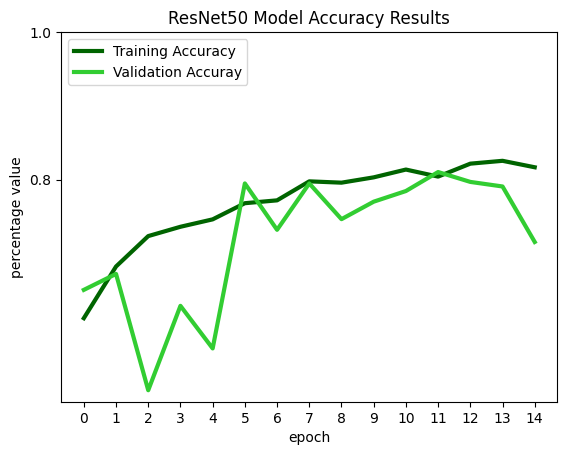

In [23]:
plt.plot(second_history.history['Accuracy'], 'darkgreen', linewidth=3)
plt.plot(second_history.history['val_Accuracy'], 'limegreen', linewidth=3)
plt.title('ResNet50 Model Accuracy Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(resnet_epochs)])
plt.yticks([0.8,1])
plt.legend(['Training Accuracy', 'Validation Accuray'], loc='upper left')
plt.show()

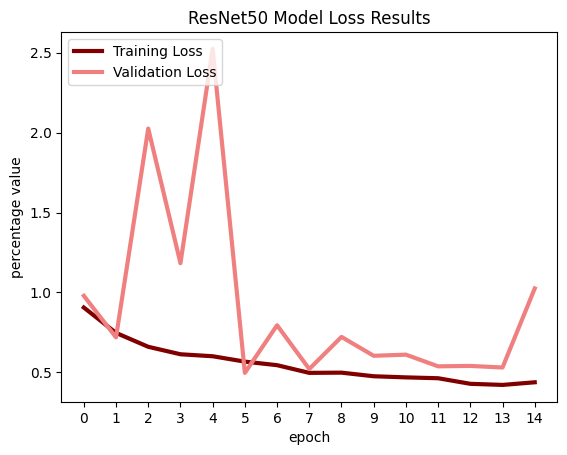

In [24]:
plt.plot(second_history.history['loss'], 'maroon', linewidth=3)
plt.plot(second_history.history['val_loss'], 'lightcoral', linewidth=3)
plt.title('ResNet50 Model Loss Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(resnet_epochs)])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [25]:
predict_test = second_model.predict(scale_data_test)
predictions = np.argmax(predict_test, axis=1)
true_classification = np.argmax(classifications_test, axis=1)

print(classification_report(true_classification, predictions))

27/27 [==============================] - 66s 2s/step
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       217
           1       0.57      0.85      0.69       212
           2       0.52      0.69      0.60       199
           3       0.95      0.46      0.62       229

    accuracy                           0.68       857
   macro avg       0.75      0.68      0.68       857
weighted avg       0.76      0.68      0.68       857



In [26]:
predict_test = second_model.predict(data_test)
predictions = np.argmax(predict_test, axis=1)
true_classification = np.argmax(classifications_test, axis=1)

print(classification_report(true_classification, predictions))

27/27 [==============================] - 61s 2s/step
              precision    recall  f1-score   support

           0       0.25      1.00      0.40       217
           1       0.00      0.00      0.00       212
           2       0.00      0.00      0.00       199
           3       0.00      0.00      0.00       229

    accuracy                           0.25       857
   macro avg       0.06      0.25      0.10       857
weighted avg       0.06      0.25      0.10       857



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
third_model = Sequential()

third_model.add(Conv2D(filters=32, kernel_size = (3,3), activation='relu', input_shape = (image_size,image_size, 3)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(filters=64, kernel_size = (3,3), activation='relu', input_shape = (image_size,image_size,3)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(filters=128, kernel_size = (3,3), activation='relu', input_shape = (image_size,image_size,3)))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Flatten())
third_model.add(Dense(512, activation='relu'))
third_model.add(Dense(4, activation='softmax'))

In [28]:
third_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics= 'Accuracy')

In [ ]:
batch_size = 32
epochs = 10

third_history = third_model.fit(x=scale_data_train, y=classifications_train,
                          validation_data=(scale_data_validation, classifications_validation),
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1)

Epoch 1/10
  9/122 [=>............................] - ETA: 3:00 - loss: 1.5384 - Accuracy: 0.3681

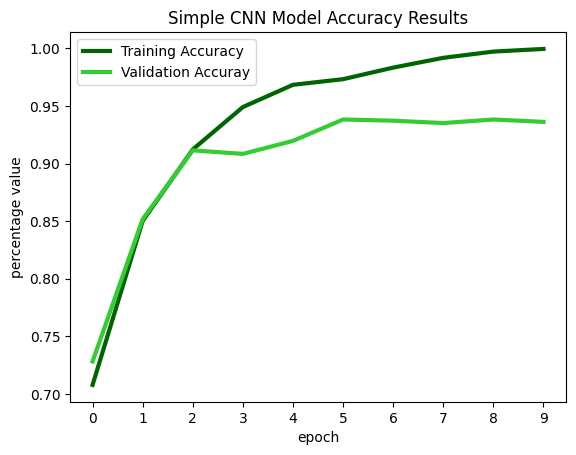

In [ ]:
plt.plot(third_history.history['Accuracy'], 'darkgreen', linewidth=3)
plt.plot(third_history.history['val_Accuracy'], 'limegreen', linewidth=3)
plt.title('Simple CNN Model Accuracy Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Accuracy', 'Validation Accuray'], loc='upper left')
plt.show()

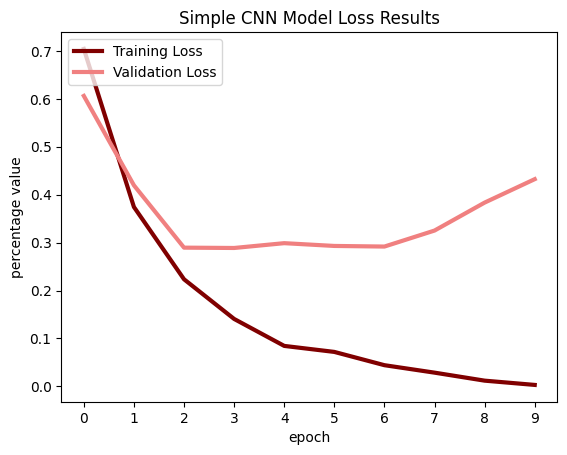

In [ ]:
plt.plot(third_history.history['loss'], 'maroon', linewidth=3)
plt.plot(third_history.history['val_loss'], 'lightcoral', linewidth=3)
plt.title('Simple CNN Model Loss Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
predict_test = third_model.predict(scale_data_test)
predictions = np.argmax(predict_test, axis=1)
true_classification = np.argmax(classifications_test, axis=1)

print(classification_report(true_classification, predictions))

27/27 [==============================] - 11s 390ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       217
           1       0.95      0.93      0.94       212
           2       0.90      0.89      0.89       199
           3       0.96      0.99      0.97       229

    accuracy                           0.95       857
   macro avg       0.94      0.94      0.94       857
weighted avg       0.94      0.95      0.95       857

